In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import importlib
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from utils.dataset import DataGenerator
from models.seq2seq import Seq2Seq

Init Plugin
Init Graph Optimizer
Init Kernel


In [9]:
INPUT_WIDTH = 21
LABEL_WIDTH = 15
LAYER_SIZE = 256
EPOCHS = 500
BATCH_SIZE = 64
ATTENTION = True

covid_fname = 'covid_20200301_20210619.csv'
model_fname = f'seq2seq_attn_iw{INPUT_WIDTH}_lw{LABEL_WIDTH}_ls{LAYER_SIZE}.h5'
feature_cols = ['decideDailyCnt']
label_cols = 'decideDailyCnt'

In [3]:
RMSE = lambda x, y: mean_squared_error(x, y, squared=False)
MAE = mean_absolute_error
MAPE = mean_absolute_percentage_error

In [4]:
def evaluation(y_true, y_pred):
    result = []
    for x, y in zip(y_true, y_pred):
        result.append([
            RMSE(x, y),
            MAE(x, y),
            MAPE(x, y)
        ])
    result = np.array(result)
    result = np.mean(result, axis=0)
    result = np.around(result, 2)
    return result

In [39]:
import pickle
covid_data = pd.read_csv(f'./data/{covid_fname}')

# scaler = MinMaxScaler()
# scaler.fit(covid_data[[label_cols]].values)
# with open(f'./data/{covid_fname[:-4]}_scaler.pkl', 'wb') as f:
#     pickle.dump(scaler, f)

with open(f'./data/{covid_fname[:-4]}_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

In [36]:
covid_data

,accDefRate,accExamCnt,accExamCompCnt,careCnt,clearCnt,createDt,deathCnt,decideCnt,examCnt,resutlNegCnt,seq,stateDt,stateTime,updateDt,decideDailyCnt
0,5.557315,109591.0,75792.0,NaN,31.0,2020-03-02 10:52:38.380,22.0,4212.0,33799.0,71580.0,61,2020-03-02 00:00:00.000,00:00,2020-03-02 10:52:38.38,476.0
1,5.329140,125851.0,90296.0,4159.0,34.0,2020-03-03 10:46:53.530,28.0,4812.0,35555.0,85484.0,62,2020-03-03 00:00:00.000,00:00,2020-03-03 10:46:53.53,600.0
2,4.919986,136707.0,108293.0,4750.0,41.0,2020-03-04 10:21:44.440,32.0,5328.0,28414.0,102965.0,63,2020-03-04 00:00:00.000,00:00,2020-03-04 10:21:44.44,516.0
3,4.622748,146541.0,124731.0,5255.0,88.0,2020-03-05 10:15:12.120,35.0,5766.0,21810.0,118965.0,64,2020-03-05 00:00:00.000,00:00,2020-03-05 10:15:12.12,438.0
4,4.397234,164740.0,142908.0,5643.0,108.0,2020-03-06 12:55:44.440,42.0,6284.0,21832.0,136624.0,65,2020-03-06 00:00:00.000,00:00,2020-03-06 12:55:44.44,518.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
470,1.475716,10196469.0,10072805.0,6921.0,139733.0,2021-06-15 09:34:07.292,1992.0,148646.0,123664.0,9924159.0,543,2021-06-15 00:00:00.000,00:00,2021-06-16 09:46:35.159,373.0
471,1.475587,10229384.0,10110620.0,6760.0,140438.0,2021-06-16 09:52:02.014,1993.0,149191.0,118764.0,9961429.0,544,2021-06-16 00:00:00.000,00:00,NaN,545.0
472,1.477145,10257836.0,10136517.0,6708.0,141029.0,2021-06-17 09:37:38.734,1994.0,149731.0,121319.0,9986786.0,545,2021-06-17 00:00:00.000,00:00,NaN,540.0
473,1.477526,10294048.0,10168211.0,6426.0,141816.0,2021-06-18 09:42:02.100,1996.0,150238.0,125837.0,10017973.0,546,2021-06-18 00:00:00.000,00:00,NaN,507.0


input size: 7
training...


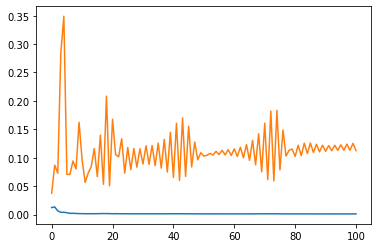

7 [0.12 0.1  0.21]
input size: 14
training...


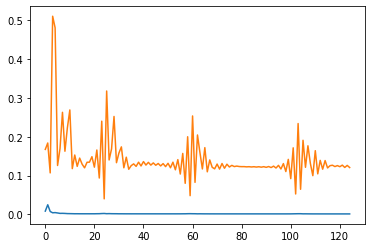

14 [0.09 0.08 0.17]
input size: 21
training...


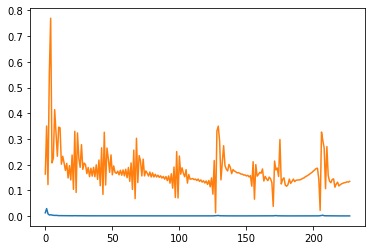

21 [0.08 0.07 0.15]
input size: 28
training...


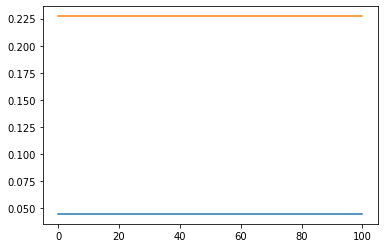

28 [0.47 0.46 1.  ]
input size: 35
training...


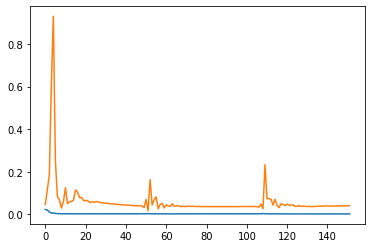

35 [0.11 0.1  0.2 ]
input size: 42
training...


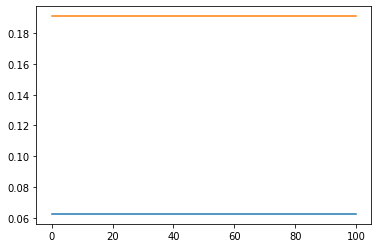

42 [0.47 0.47 1.  ]


In [16]:
for input_size in [7, 14, 21, 28, 35, 42]:
    print('input size:', input_size)

    data_gen = DataGenerator(raw_data=covid_data,
                            input_width=input_size, label_width=LABEL_WIDTH,
                            feature_cols=feature_cols,
                            label_cols=label_cols,
                            train_split=0.6, val_split=0.2, test_split=0.2)

    model_fname = f'seq2seq_attn_daily_iw{input_size}_lw{LABEL_WIDTH}_ls{LAYER_SIZE}.h5'

    tf.keras.backend.clear_session()
    train_callbacks = [tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True),
                        tf.keras.callbacks.ModelCheckpoint(filepath=f'./models/{model_fname}', save_best_only=True, save_weights_only=True)]

    seq2seq_attn = Seq2Seq(units=LAYER_SIZE, 
                            input_width=input_size, feature_num=len(feature_cols),
                            label_width=LABEL_WIDTH, attention=ATTENTION)
    
    print('training...')
    
    history = seq2seq_attn.train(data_gen.train.batch(BATCH_SIZE), 
                                val_ds=data_gen.val.batch(BATCH_SIZE),
                                epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
                                callbacks=train_callbacks)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

    for inp, targ in data_gen.test.batch(512).take(1):
        preds = seq2seq_attn.predict(inp)

    inverse_targ = scaler.inverse_transform(targ)
    inverse_preds = scaler.inverse_transform(preds)
    print(input_size, evaluation(inverse_targ, inverse_preds))


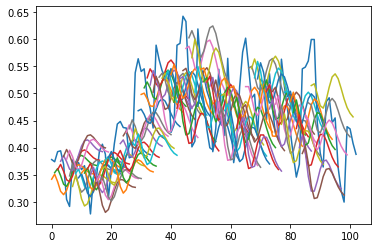

21 [104.51  88.36   0.15]


In [30]:
input_size = 21

data_gen = DataGenerator(raw_data=covid_data,
                        input_width=input_size, label_width=LABEL_WIDTH,
                        feature_cols=feature_cols,
                        label_cols=label_cols,
                        train_split=0.6, val_split=0.2, test_split=0.2)

model_fname = f'seq2seq_attn_daily_iw{input_size}_lw{LABEL_WIDTH}_ls{LAYER_SIZE}.h5'

test_seq2seq = Seq2Seq(units=LAYER_SIZE, 
                        input_width=input_size, feature_num=len(feature_cols),
                        label_width=LABEL_WIDTH, attention=ATTENTION)
test_seq2seq.model.load_weights(f'./models/{model_fname}')

for inp, targ in data_gen.test.batch(512).take(1):
    preds = test_seq2seq.predict(inp)

plt.plot(tf.concat([targ[:, 0], targ[-1, :]], axis=0))
for i, pred in enumerate(preds):
    plt.plot(range(i, i+LABEL_WIDTH), pred)
plt.show()

inverse_targ = scaler.inverse_transform(targ)
inverse_preds = scaler.inverse_transform(preds)
print(input_size, evaluation(inverse_targ, inverse_preds))

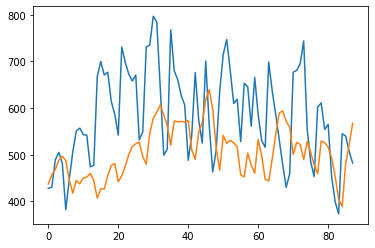

In [35]:
step = 14

plt.plot(inverse_targ[:, step])
plt.plot(inverse_preds[:, step])
plt.show()

layer size: 64
training...


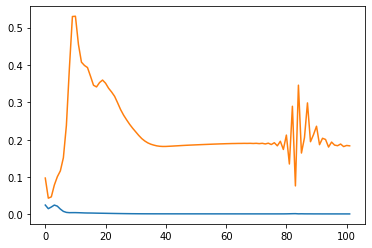

21 [186.98 161.38   0.26]
layer size: 128
training...


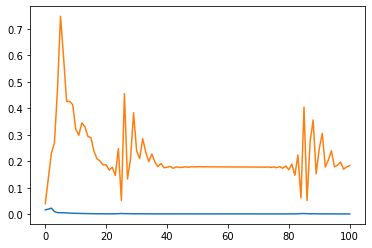

21 [149.56 122.36   0.2 ]
layer size: 512
training...


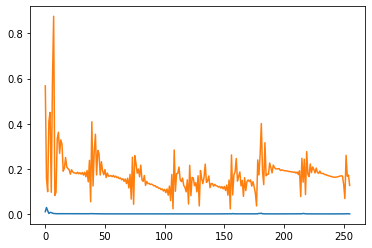

21 [110.18  93.5    0.17]


In [37]:
for layer_size in [64, 128, 512]:
    print('layer size:', layer_size)

    data_gen = DataGenerator(raw_data=covid_data,
                            input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
                            feature_cols=feature_cols,
                            label_cols=label_cols,
                            train_split=0.6, val_split=0.2, test_split=0.2)

    model_fname = f'seq2seq_attn_daily_iw{INPUT_WIDTH}_lw{LABEL_WIDTH}_ls{layer_size}.h5'

    tf.keras.backend.clear_session()
    train_callbacks = [tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True),
                        tf.keras.callbacks.ModelCheckpoint(filepath=f'./models/{model_fname}', save_best_only=True, save_weights_only=True)]

    seq2seq_attn = Seq2Seq(units=layer_size, 
                            input_width=INPUT_WIDTH, feature_num=len(feature_cols),
                            label_width=LABEL_WIDTH, attention=ATTENTION)
    
    print('training...')
    
    history = seq2seq_attn.train(data_gen.train.batch(BATCH_SIZE), 
                                val_ds=data_gen.val.batch(BATCH_SIZE),
                                epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
                                callbacks=train_callbacks)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()

    for inp, targ in data_gen.test.batch(512).take(1):
        preds = seq2seq_attn.predict(inp)

    inverse_targ = scaler.inverse_transform(targ)
    inverse_preds = scaler.inverse_transform(preds)
    print(input_size, evaluation(inverse_targ, inverse_preds))


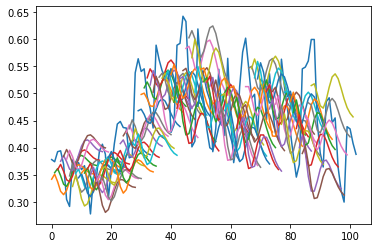

[104.51  88.36   0.15]


In [21]:
layer_size = 256

data_gen = DataGenerator(raw_data=covid_data,
                        input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
                        feature_cols=feature_cols,
                        label_cols=label_cols,
                        train_split=0.6, val_split=0.2, test_split=0.2)

model_fname = f'seq2seq_attn_daily_iw{INPUT_WIDTH}_lw{LABEL_WIDTH}_ls{layer_size}.h5'

test_seq2seq = Seq2Seq(units=layer_size, 
                        input_width=INPUT_WIDTH, feature_num=len(feature_cols),
                        label_width=LABEL_WIDTH, attention=ATTENTION)
test_seq2seq.model.load_weights(f'./models/{model_fname}')

for inp, targ in data_gen.test.batch(512).take(1):
    preds = test_seq2seq.predict(inp)

plt.plot(tf.concat([targ[:, 0], targ[-1, :]], axis=0))
for i, pred in enumerate(preds):
    plt.plot(range(i, i+LABEL_WIDTH), pred)
plt.show()

inverse_targ = scaler.inverse_transform(targ)
inverse_preds = scaler.inverse_transform(preds)
print(evaluation(inverse_targ, inverse_preds))

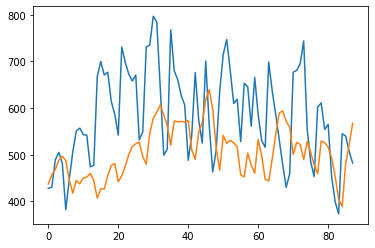

In [22]:
step = 14

plt.plot(inverse_targ[:, step])
plt.plot(inverse_preds[:, step])
plt.show()

training...


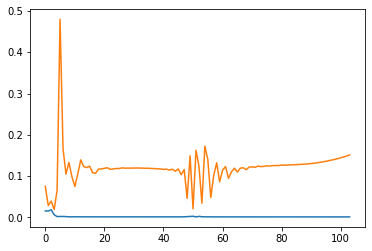

[129.23 110.84   0.18]


In [8]:
data_gen = DataGenerator(raw_data=covid_data,
                        input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
                        feature_cols=feature_cols,
                        label_cols=label_cols,
                        train_split=0.6, val_split=0.2, test_split=0.2)

model_fname = f'seq2seq_daily_iw{INPUT_WIDTH}_lw{LABEL_WIDTH}_ls{LAYER_SIZE}.h5'

tf.keras.backend.clear_session()
train_callbacks = [tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True),
                    tf.keras.callbacks.ModelCheckpoint(filepath=f'./models/{model_fname}', save_best_only=True, save_weights_only=True)]

seq2seq_attn = Seq2Seq(units=LAYER_SIZE, 
                        input_width=INPUT_WIDTH, feature_num=len(feature_cols),
                        label_width=LABEL_WIDTH, attention=False)

print('training...')

history = seq2seq_attn.train(data_gen.train.batch(BATCH_SIZE), 
                            val_ds=data_gen.val.batch(BATCH_SIZE),
                            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
                            callbacks=train_callbacks)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

for inp, targ in data_gen.test.batch(512).take(1):
    preds = seq2seq_attn.predict(inp)

inverse_targ = scaler.inverse_transform(targ)
inverse_preds = scaler.inverse_transform(preds)
print(evaluation(inverse_targ, inverse_preds))


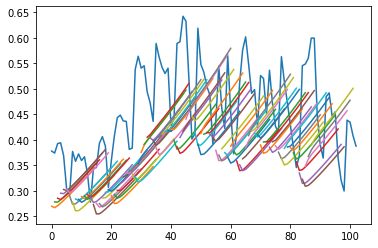

[129.23 110.84   0.18]


In [9]:
data_gen = DataGenerator(raw_data=covid_data,
                        input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
                        feature_cols=feature_cols,
                        label_cols=label_cols,
                        train_split=0.6, val_split=0.2, test_split=0.2)

model_fname = f'seq2seq_daily_iw{INPUT_WIDTH}_lw{LABEL_WIDTH}_ls{LAYER_SIZE}.h5'

test_seq2seq = Seq2Seq(units=LAYER_SIZE, 
                        input_width=INPUT_WIDTH, feature_num=len(feature_cols),
                        label_width=LABEL_WIDTH, attention=False)
test_seq2seq.model.load_weights(f'./models/{model_fname}')

for inp, targ in data_gen.test.batch(512).take(1):
    preds = test_seq2seq.predict(inp)

plt.plot(tf.concat([targ[:, 0], targ[-1, :]], axis=0))
for i, pred in enumerate(preds):
    plt.plot(range(i, i+LABEL_WIDTH), pred)
plt.show()

inverse_targ = scaler.inverse_transform(targ)
inverse_preds = scaler.inverse_transform(preds)
print(evaluation(inverse_targ, inverse_preds))

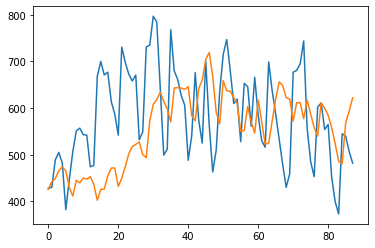

In [11]:
step = 14

plt.plot(inverse_targ[:, step])
plt.plot(inverse_preds[:, step])
plt.show()

training...


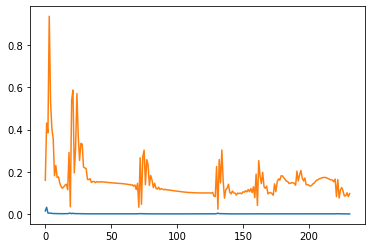

[111.92  95.6    0.16]


In [37]:
target_feature_cols = feature_cols+['examCntNorm', 'accDefRateNorm']

data_gen = DataGenerator(raw_data=covid_data,
                        input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
                        feature_cols=target_feature_cols,
                        label_cols=label_cols,
                        train_split=0.6, val_split=0.2, test_split=0.2)

model_fname = f'seq2seq_attn_daily+examCnt+accDefRate_iw{INPUT_WIDTH}_lw{LABEL_WIDTH}_ls{LAYER_SIZE}.h5'

tf.keras.backend.clear_session()
train_callbacks = [tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True),
                    tf.keras.callbacks.ModelCheckpoint(filepath=f'./models/{model_fname}', save_best_only=True, save_weights_only=True)]

seq2seq_attn = Seq2Seq(units=LAYER_SIZE, 
                        input_width=INPUT_WIDTH, feature_num=len(target_feature_cols),
                        label_width=LABEL_WIDTH, attention=ATTENTION)

print('training...')

history = seq2seq_attn.train(data_gen.train.batch(BATCH_SIZE), 
                            val_ds=data_gen.val.batch(BATCH_SIZE),
                            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
                            callbacks=train_callbacks)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

for inp, targ in data_gen.test.batch(512).take(1):
    preds = seq2seq_attn.predict(inp)

inverse_targ = scaler.inverse_transform(targ)
inverse_preds = scaler.inverse_transform(preds)
print(evaluation(inverse_targ, inverse_preds))


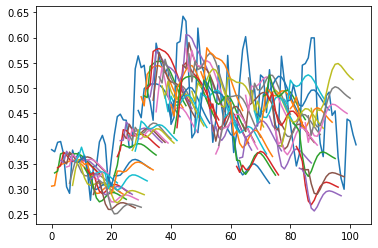

[119.01 100.48   0.17]


In [58]:
target_feature_cols = feature_cols+['examCntNorm']

data_gen = DataGenerator(raw_data=covid_data,
                        input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
                        feature_cols=target_feature_cols,
                        label_cols=label_cols,
                        train_split=0.6, val_split=0.2, test_split=0.2)

model_fname = f'seq2seq_attn_daily+examCnt_iw{INPUT_WIDTH}_lw{LABEL_WIDTH}_ls{LAYER_SIZE}.h5'

test_seq2seq = Seq2Seq(units=LAYER_SIZE, 
                        input_width=INPUT_WIDTH, feature_num=len(target_feature_cols),
                        label_width=LABEL_WIDTH, attention=ATTENTION)
test_seq2seq.model.load_weights(f'./models/{model_fname}')

for inp, targ in data_gen.test.batch(512).take(1):
    preds = test_seq2seq.predict(inp)

plt.plot(tf.concat([targ[:, 0], targ[-1, :]], axis=0))
for i, pred in enumerate(preds):
    plt.plot(range(i, i+LABEL_WIDTH), pred)
plt.show()

inverse_targ = scaler.inverse_transform(targ)
inverse_preds = scaler.inverse_transform(preds)
print(evaluation(inverse_targ, inverse_preds))

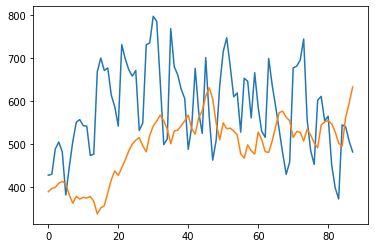

In [40]:
step = 14

plt.plot(inverse_targ[:, step])
plt.plot(inverse_preds[:, step])
plt.show()

training...


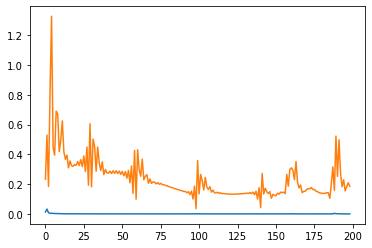

[114.9   97.11   0.18]


In [16]:
target_feature_cols = feature_cols+['examCnt']

data_gen = DataGenerator(raw_data=covid_data,
                        input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
                        feature_cols=target_feature_cols,
                        label_cols=label_cols,
                        norm=True,
                        train_split=0.6, val_split=0.2, test_split=0.2)

model_fname = f'ds_norm_test.h5'

tf.keras.backend.clear_session()
train_callbacks = [tf.keras.callbacks.EarlyStopping(patience=100, restore_best_weights=True),
                    tf.keras.callbacks.ModelCheckpoint(filepath=f'./models/{model_fname}', save_best_only=True, save_weights_only=True)]

seq2seq_attn = Seq2Seq(units=LAYER_SIZE, 
                        input_width=INPUT_WIDTH, feature_num=len(target_feature_cols),
                        label_width=LABEL_WIDTH, attention=ATTENTION)

print('training...')

history = seq2seq_attn.train(data_gen.train.batch(BATCH_SIZE), 
                            val_ds=data_gen.val.batch(BATCH_SIZE),
                            epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0,
                            callbacks=train_callbacks)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

for inp, targ in data_gen.test.batch(512).take(1):
    preds = seq2seq_attn.predict(inp)

inverse_targ = scaler.inverse_transform(targ)
inverse_preds = scaler.inverse_transform(preds)
print(evaluation(inverse_targ, inverse_preds))


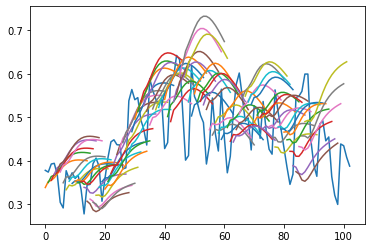

[114.9   97.11   0.18]


In [17]:
target_feature_cols = feature_cols+['examCnt']

data_gen = DataGenerator(raw_data=covid_data,
                        input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
                        feature_cols=target_feature_cols,
                        label_cols=label_cols,
                        norm=True,
                        train_split=0.6, val_split=0.2, test_split=0.2)

model_fname = f'ds_norm_test.h5'

test_seq2seq = Seq2Seq(units=LAYER_SIZE, 
                        input_width=INPUT_WIDTH, feature_num=len(target_feature_cols),
                        label_width=LABEL_WIDTH, attention=ATTENTION)
test_seq2seq.model.load_weights(f'./models/{model_fname}')

for inp, targ in data_gen.test.batch(512).take(1):
    preds = test_seq2seq.predict(inp)

plt.plot(tf.concat([targ[:, 0], targ[-1, :]], axis=0))
for i, pred in enumerate(preds):
    plt.plot(range(i, i+LABEL_WIDTH), pred)
plt.show()

inverse_targ = scaler.inverse_transform(targ)
inverse_preds = scaler.inverse_transform(preds)
print(evaluation(inverse_targ, inverse_preds))

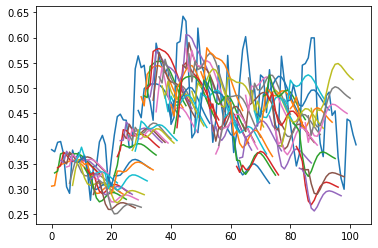

[119.01 100.48   0.17]


In [24]:
target_feature_cols = feature_cols+['examCnt']

data_gen = DataGenerator(raw_data=covid_data,
                        input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
                        feature_cols=target_feature_cols,
                        label_cols=label_cols,
                        norm=True,
                        train_split=0.6, val_split=0.2, test_split=0.2)

model_fname = f'seq2seq_attn_daily+examCnt_iw{INPUT_WIDTH}_lw{LABEL_WIDTH}_ls{LAYER_SIZE}.h5'

test_seq2seq = Seq2Seq(units=LAYER_SIZE, 
                        input_width=INPUT_WIDTH, feature_num=len(target_feature_cols),
                        label_width=LABEL_WIDTH, attention=ATTENTION)
test_seq2seq.model.load_weights(f'./models/{model_fname}')

for inp, targ in data_gen.test.batch(512).take(1):
    preds = test_seq2seq.predict(inp)

plt.plot(tf.concat([targ[:, 0], targ[-1, :]], axis=0))
for i, pred in enumerate(preds):
    plt.plot(range(i, i+LABEL_WIDTH), pred)
plt.show()

inverse_targ = scaler.inverse_transform(targ)
inverse_preds = scaler.inverse_transform(preds)
print(evaluation(inverse_targ, inverse_preds))